In [1]:
# pip install diffusers transformers accelerate scipy safetensors

In [2]:
%cd ..

/Users/ollin/Desktop/fast_sd_decoder/fast_sd_decoder_github


In [3]:
import torch
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=None if torch.backends.mps.is_available() else torch.float16)  

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
pipe = pipe.to(device)
pipe.enable_attention_slicing()

In [5]:
import taesd
import time
from PIL import Image
import numpy as np

taesd_dec = taesd.Decoder().to(device)
taesd_dec.load_state_dict(torch.load("taesd_decoder.pth", map_location=device))

def get_pred_original_sample(sched, model_output, timestep, sample):
    alpha_prod_t = sched.alphas_cumprod[timestep]
    return (sample - (1 - alpha_prod_t) ** 0.5 * model_output) / alpha_prod_t ** 0.5

preview_images = []
preview_handle = None

def add_taesd_previewing(pipe, taesd_dec):
    sched = pipe.scheduler
    if not hasattr(sched, "_step"):
        sched._step = sched.step
    def step_and_preview(*args, **kwargs):
        global preview_images, preview_handle
        # step
        res = sched._step(*args, **kwargs)
        # preview
        latents = get_pred_original_sample(sched, *args)
        with torch.no_grad():
            decoded = taesd_dec(latents.float()).clamp(0, 1).mul_(255).round().byte()
        decoded = Image.fromarray(decoded[0].permute(1, 2, 0).cpu().numpy())
        preview_images.append(decoded)
        if preview_handle is None:
            preview_handle = display(decoded, display_id=True)
        else:
            preview_handle.update(decoded)
        return res
    sched.step = step_and_preview
    
def add_final_speed_comparison(pipe, taesd_dec):
    if not hasattr(pipe, "_decode_latents"):
        pipe._decode_latents = pipe.decode_latents
    def decode_latents_and_compare_speeds(latents):
        tick_sd = time.time()
        res_sd = pipe._decode_latents(latents)
        tock_sd = tick_taesd = time.time()
        res_taesd = taesd_dec(latents).cpu().permute(0, 2, 3, 1).float().clamp(0, 1).numpy()
        tock_taesd = time.time()
        print("To decode these latents")
        display(Image.fromarray(latents[0, :3].mul(0.25).add(0.5).clamp(0, 1).mul(255).round().byte().permute(1, 2, 0).cpu().numpy()))
        print(f"SD (left) takes \033[34m{tock_sd - tick_sd:.4f}s\033[0m; taesd (right) takes \033[36m{tock_taesd - tick_taesd:.4f}s\033[0m")
        return np.concatenate([res_sd, res_taesd], -2)
    pipe.decode_latents = decode_latents_and_compare_speeds

add_taesd_previewing(pipe, taesd_dec)
add_final_speed_comparison(pipe, taesd_dec)

In [6]:
prompt = "slice of delicious New York-style berry cheesecake"

  0%|          | 0/26 [00:00<?, ?it/s]

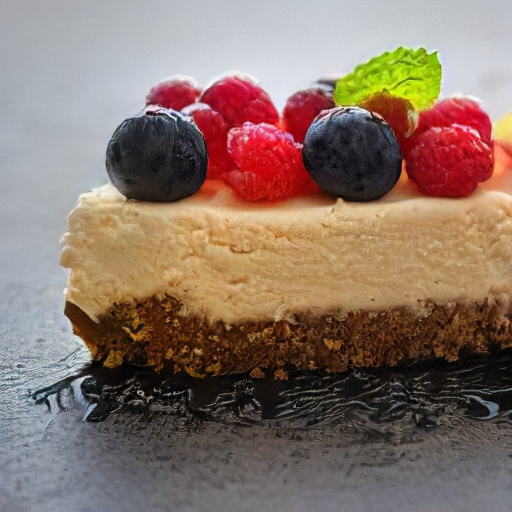

To decode these latents


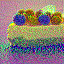

SD (left) takes 1.2585s; taesd (right) takes 0.0574s


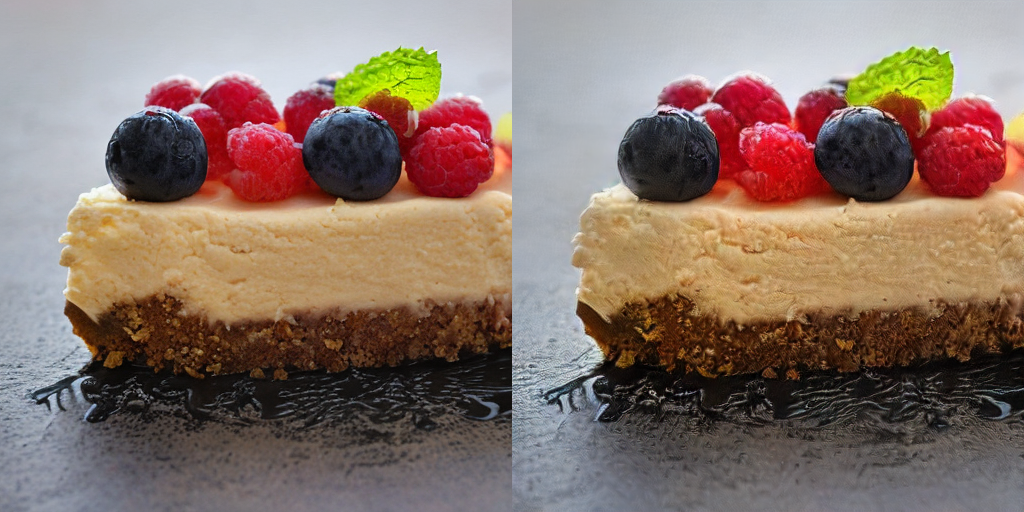

In [7]:
preview_images.clear()
preview_handle = None
image = pipe(prompt, num_inference_steps=25, height=512, width=512, guidance_scale=3.0).images[0]
display(image)

In [8]:
from IPython.display import Markdown
preview_images[0].save("preview_images.gif", save_all=True, append_images=preview_images[1:], duration=100, loop=0)
Markdown(f"![](../preview_images.gif?cache_break={torch.rand(1).item()})")

![](../preview_images.gif?cache_break=0.3033144474029541)